# Building Makemore Part 2: Multi-Layer Perceptron

[Reference Video](https://youtu.be/TCH_1BHY58I?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

[Reference Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Part 1: Explore the Dataset

In [150]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [151]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [152]:
len(words)

32033

## Part 2: Label the Dataset

In [153]:
# mappings from letter to index, and index to letter
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [154]:
# build an adjustable block-size
block_size = 3
X, Y = [], [] # inputs and labels
for w in words[:5]:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # shift context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [155]:
X[:4], Y[:4]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13]]),
 tensor([ 5, 13, 13,  1]))

## Part 3: Semantic Character Representation in a 2-D Space

### 3.1 Image of neural net from [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) by Bergio et. al.

![Image of neural net for reference](./network.png)


In [156]:
# build a character embedding in a 2-dim space
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27,2, generator=g)
C.shape, C[:4]

(torch.Size([27, 2]),
 tensor([[ 1.5674, -0.2373],
         [-0.0274, -1.1008],
         [ 0.2859, -0.0296],
         [-1.5471,  0.6049]]))

### 3.2 Pull a name out of the Character Embedding

In [157]:
# index the character embedding using a word
name = []
for w in words[:1]:
    for ch in w + '.':
        ix = stoi[ch]
        name.append(ix) # indices of name 'emma
    
C[name] # embedding of name 'emma'

tensor([[-0.4713,  0.7868],
        [ 2.4448, -0.6701],
        [ 2.4448, -0.6701],
        [-0.0274, -1.1008],
        [ 1.5674, -0.2373]])

### 3.3: Embedding the entire data set

In `emb`, the embedding of our entire dataset of characater sequences (trigrams, in the most naive approach), the first axis denotes each character sequence used as context (ex. previous 3 letters). Then, the second axis indexes which character in the sequence (first, second, or third). And finally, the third axis denotes the elmenents of the n-dimensional space of character embeddings

In [158]:
# embed the entire dataset
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [159]:

W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)

In [160]:
# emb @ W1 + b1 # What we want to do.

### 3.4: Wrangling the embedding data (Naive approach)

In [161]:
# Naive approach to concatentating embeddings of each trigram into an (n, 6) array
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)[:10]


tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078]])

In [162]:
# unbind the trigrams, achieve same as above
torch.cat(torch.unbind(emb, 1), 1)[:10] # (n, 6) shape instead of (n, 3, 2)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078]])

#### Summary of 3.4: 

We started off with a tensor of dimension `(n, block_size, embedding_space_dim)`.

Then, for each n-gram or block of characters, we used `torch.unbind` and then `torch.cat` to concatentate each embedding along eachother.

So, if we now use a trigram with character embeddings in a 2-dimensional space, we will then have a 6-element long input to the network.

### 3.5: More efficient approach using `tensor.view`

[ezyang's blog post on PyTorch internals](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [163]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [164]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [165]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [166]:
# Reshape the embedding efficiently
emb = C[X]

emb = emb.view(emb.shape[0], 6) 
# OR
emb = emb.view(emb.shape[0], -1) # -1 means "whatever is needed to make the shape work"

## Part 2: Building the network

### 2.1: Hidden Layer

Since we already reshaped our data, the input layer is done.

Now we will create the hidden layer.

In [167]:
emb @ W1 + b1 # Works now !

tensor([[-1.6952e+00,  8.5502e+00,  1.6284e+00,  ...,  2.2642e+00,
         -1.9505e-01,  1.8469e+00],
        [ 2.8741e-01,  4.3343e+00,  1.0142e+00,  ...,  2.8221e+00,
          3.9128e+00,  3.4733e+00],
        [-3.1026e+00,  9.9601e+00, -1.3306e+00,  ..., -5.7069e-01,
         -5.9107e+00, -6.9120e-03],
        ...,
        [-4.3248e+00,  7.4938e+00, -1.6386e+00,  ..., -5.1557e+00,
         -3.3276e+00, -3.2464e+00],
        [-1.4951e+00,  5.6195e+00,  2.5079e+00,  ..., -1.0607e+00,
         -5.2543e-01,  3.4893e+00],
        [-1.4982e+00,  8.5941e+00,  1.8897e+00,  ...,  2.4983e+00,
          6.9596e+00,  2.6822e+00]])

In [168]:
# Hidden layer activation using tanh
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden layer activation
h.shape

torch.Size([32, 100])

In [169]:
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

In [170]:
logits = h @ W2 + b2 # log counts
logits.shape

torch.Size([32, 27])

Text(0.5, 0, 'Probability of each character output')

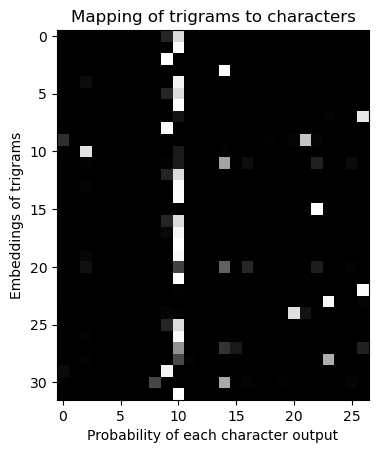

In [171]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
plt.imshow(probs.detach().numpy(), cmap='gray')
plt.title("Mapping of trigrams to characters")
plt.ylabel("Embeddings of trigrams")
plt.xlabel("Probability of each character output")

In [172]:
probs[:, 1] # probabiility of letter 'a' for each trigram

tensor([2.0283e-10, 9.0695e-12, 1.5368e-13, 3.1758e-10, 3.0845e-09, 2.0283e-10,
        3.0830e-12, 3.2550e-11, 1.6815e-12, 2.0269e-09, 5.3863e-08, 2.8552e-06,
        2.0283e-10, 2.6391e-09, 6.2336e-07, 3.5843e-08, 2.0283e-10, 2.8360e-10,
        2.0670e-09, 1.7086e-08, 1.6384e-09, 4.1033e-14, 8.1859e-12, 5.6464e-15,
        1.5201e-10, 2.0283e-10, 9.9325e-10, 5.6630e-08, 2.7953e-11, 6.6081e-15,
        9.7404e-10, 9.1782e-12])

## Part 3: Loss function

We will use the negative log likelihood as the loss function, to east computation and so that minimizing the loss function means optimizing the network.

Previously, we manually calculated each step of the negative log likelihood, now we will use Torch's `cross_entropy` function that takes in the logits, and outputs the negative log likelihood as shown below. This is also much more efficient, and better able to handle a larger range of inputs (without getting exploding `.exp()` numbers)

In [173]:
-probs[torch.arange(32), Y].log().mean()

tensor(17.7697)

In [174]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

## Part 4: Training the net

#### Definitions:

<strong>Batch Gradient Descent (super slow, but accurate)</strong>: Gradient Descent in which every training example is used to characterize the gradient of the loss function, in each step in training. 

<strong>Stochastic Gradient Descent (fast, but inaccurate)</strong> Gradient descent in which only one training example is used to approximate the gradient of the loss function at each step of training. 

<strong>Mini-Batch Gradient Descent(balance of speed and accuracy)</strong> Gradient descent in which a mini-batch of samples is used to approximate the gradient of the loss function at each step of training.

#### Approach:

We will first try full-batch gradient descent, see how slow it is, then use mini-batches.

### 4.1: Gradient descent (full-batch)

This will use the entire dataset for each forward pass and backward pass. This is extremely inefficient and we will optimize this later.

In [175]:
# use whole dataset
block_size = 3
X, Y = [], [] # inputs and labels
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # shift context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [176]:
# redo everything compactly
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [177]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 3481


In [178]:
%%timeit -r 1 -n 1
eta = 0.1
epochs = 10
for epoch in range(epochs):
    emb = C[X]
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y)
    print(f"Epoch {epoch+1}: {loss.item():.3f}")
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 1: 19.505
Epoch 2: 17.084
Epoch 3: 15.777
Epoch 4: 14.833
Epoch 5: 14.003
Epoch 6: 13.253
Epoch 7: 12.580
Epoch 8: 11.983
Epoch 9: 11.471
Epoch 10: 11.052
4.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### 4.2: Mini-batch gradient descent

In [179]:
# reinitialize meta-parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 3481


In [180]:
%%timeit -r 1 -n 1

eta = 0.1
epochs = 100
batch_size = 32


for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    emb = C[X[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 0: 20.523
Epoch 1: 18.490
Epoch 2: 14.398
Epoch 3: 12.556
Epoch 4: 13.703
Epoch 5: 14.939
Epoch 6: 13.205
Epoch 7: 11.056
Epoch 8: 10.533
Epoch 9: 10.397
Epoch 10: 9.616
Epoch 11: 9.049
Epoch 12: 8.429
Epoch 13: 9.007
Epoch 14: 7.553
Epoch 15: 8.789
Epoch 16: 8.236
Epoch 17: 9.397
Epoch 18: 8.333
Epoch 19: 9.298
Epoch 20: 7.531
Epoch 21: 10.312
Epoch 22: 8.333
Epoch 23: 10.283
Epoch 24: 7.658
Epoch 25: 7.845
Epoch 26: 8.335
Epoch 27: 7.350
Epoch 28: 8.843
Epoch 29: 5.632
Epoch 30: 6.937
Epoch 31: 6.001
Epoch 32: 7.237
Epoch 33: 8.366
Epoch 34: 5.936
Epoch 35: 5.109
Epoch 36: 6.280
Epoch 37: 4.786
Epoch 38: 7.739
Epoch 39: 6.679
Epoch 40: 5.732
Epoch 41: 6.552
Epoch 42: 7.832
Epoch 43: 4.211
Epoch 44: 6.036
Epoch 45: 5.271
Epoch 46: 5.889
Epoch 47: 6.130
Epoch 48: 5.676
Epoch 49: 5.302
Epoch 50: 6.342
Epoch 51: 5.894
Epoch 52: 4.657
Epoch 53: 5.747
Epoch 54: 5.250
Epoch 55: 3.754
Epoch 56: 5.668
Epoch 57: 4.389
Epoch 58: 3.754
Epoch 59: 6.365
Epoch 60: 5.070
Epoch 61: 4.743
Epoch 

### 4.3: Variable learning rate

In [181]:
# reinitialize meta-parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 3481


In [182]:
eta = 0.0001
epochs = 10000
batch_size = 128


for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    emb = C[X[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 0: 19.388
Epoch 1: 18.611
Epoch 2: 19.280
Epoch 3: 18.592
Epoch 4: 19.369
Epoch 5: 19.998
Epoch 6: 20.104
Epoch 7: 18.779
Epoch 8: 18.686
Epoch 9: 19.273
Epoch 10: 18.882
Epoch 11: 19.294
Epoch 12: 18.123
Epoch 13: 20.352
Epoch 14: 20.289
Epoch 15: 20.320
Epoch 16: 19.669
Epoch 17: 21.084
Epoch 18: 19.486
Epoch 19: 19.931
Epoch 20: 20.545
Epoch 21: 19.227
Epoch 22: 18.809
Epoch 23: 19.630
Epoch 24: 19.699
Epoch 25: 19.802
Epoch 26: 19.296
Epoch 27: 19.037
Epoch 28: 18.904
Epoch 29: 18.939
Epoch 30: 18.887
Epoch 31: 19.639
Epoch 32: 20.222
Epoch 33: 19.673
Epoch 34: 19.818
Epoch 35: 18.681
Epoch 36: 18.857
Epoch 37: 19.407
Epoch 38: 19.036
Epoch 39: 19.735
Epoch 40: 19.591
Epoch 41: 20.282
Epoch 42: 19.326
Epoch 43: 19.360
Epoch 44: 18.653
Epoch 45: 20.027
Epoch 46: 18.183
Epoch 47: 17.459
Epoch 48: 19.933
Epoch 49: 18.400
Epoch 50: 18.944
Epoch 51: 19.589
Epoch 52: 18.987
Epoch 53: 19.601
Epoch 54: 19.654
Epoch 55: 18.937
Epoch 56: 21.422
Epoch 57: 19.380
Epoch 58: 21.042
Epoch 5

### 4.4 Train / validation / test data splits

Typically, we use 80/10/10 percentage splits between training, validation, and test data as to not overfit the validation or test data

Here, we will also increase the size of the hidden layer and see if we can obtain performance increases

In [183]:
def build_dataset(words):
    block_size = 3
    X, Y = [], [] # inputs and labels
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # shift context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80% of data
X_valid, Y_valid = build_dataset(words[n1:n2]) # 10% of data
X_test, Y_test = build_dataset(words[n2:]) # 10% of data

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [184]:
# reinitialize meta-parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 10281


In [185]:
eta = 0.001
epochs = 10000
batch_size = 64
losses = []

for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y_train[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    losses.append(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 0: 27.851
Epoch 1: 27.920
Epoch 2: 25.754
Epoch 3: 27.490
Epoch 4: 26.770
Epoch 5: 23.349
Epoch 6: 24.987
Epoch 7: 25.287
Epoch 8: 23.467
Epoch 9: 24.725
Epoch 10: 26.640
Epoch 11: 24.947
Epoch 12: 25.147
Epoch 13: 20.590
Epoch 14: 28.549
Epoch 15: 27.311
Epoch 16: 25.229
Epoch 17: 25.427
Epoch 18: 25.752
Epoch 19: 24.467
Epoch 20: 22.251
Epoch 21: 22.457
Epoch 22: 26.661
Epoch 23: 24.329
Epoch 24: 24.611
Epoch 25: 26.040
Epoch 26: 22.904
Epoch 27: 24.492
Epoch 28: 25.109
Epoch 29: 25.839
Epoch 30: 23.305
Epoch 31: 25.298
Epoch 32: 24.265
Epoch 33: 26.973
Epoch 34: 24.153
Epoch 35: 25.203
Epoch 36: 26.810
Epoch 37: 21.920
Epoch 38: 21.569
Epoch 39: 24.763
Epoch 40: 25.264
Epoch 41: 23.996
Epoch 42: 24.323
Epoch 43: 25.726
Epoch 44: 25.689
Epoch 45: 23.783
Epoch 46: 22.875
Epoch 47: 23.252
Epoch 48: 19.547
Epoch 49: 23.629
Epoch 50: 23.951
Epoch 51: 25.859
Epoch 52: 24.985
Epoch 53: 27.269
Epoch 54: 23.730
Epoch 55: 26.326
Epoch 56: 23.837
Epoch 57: 26.028
Epoch 58: 22.746
Epoch 5

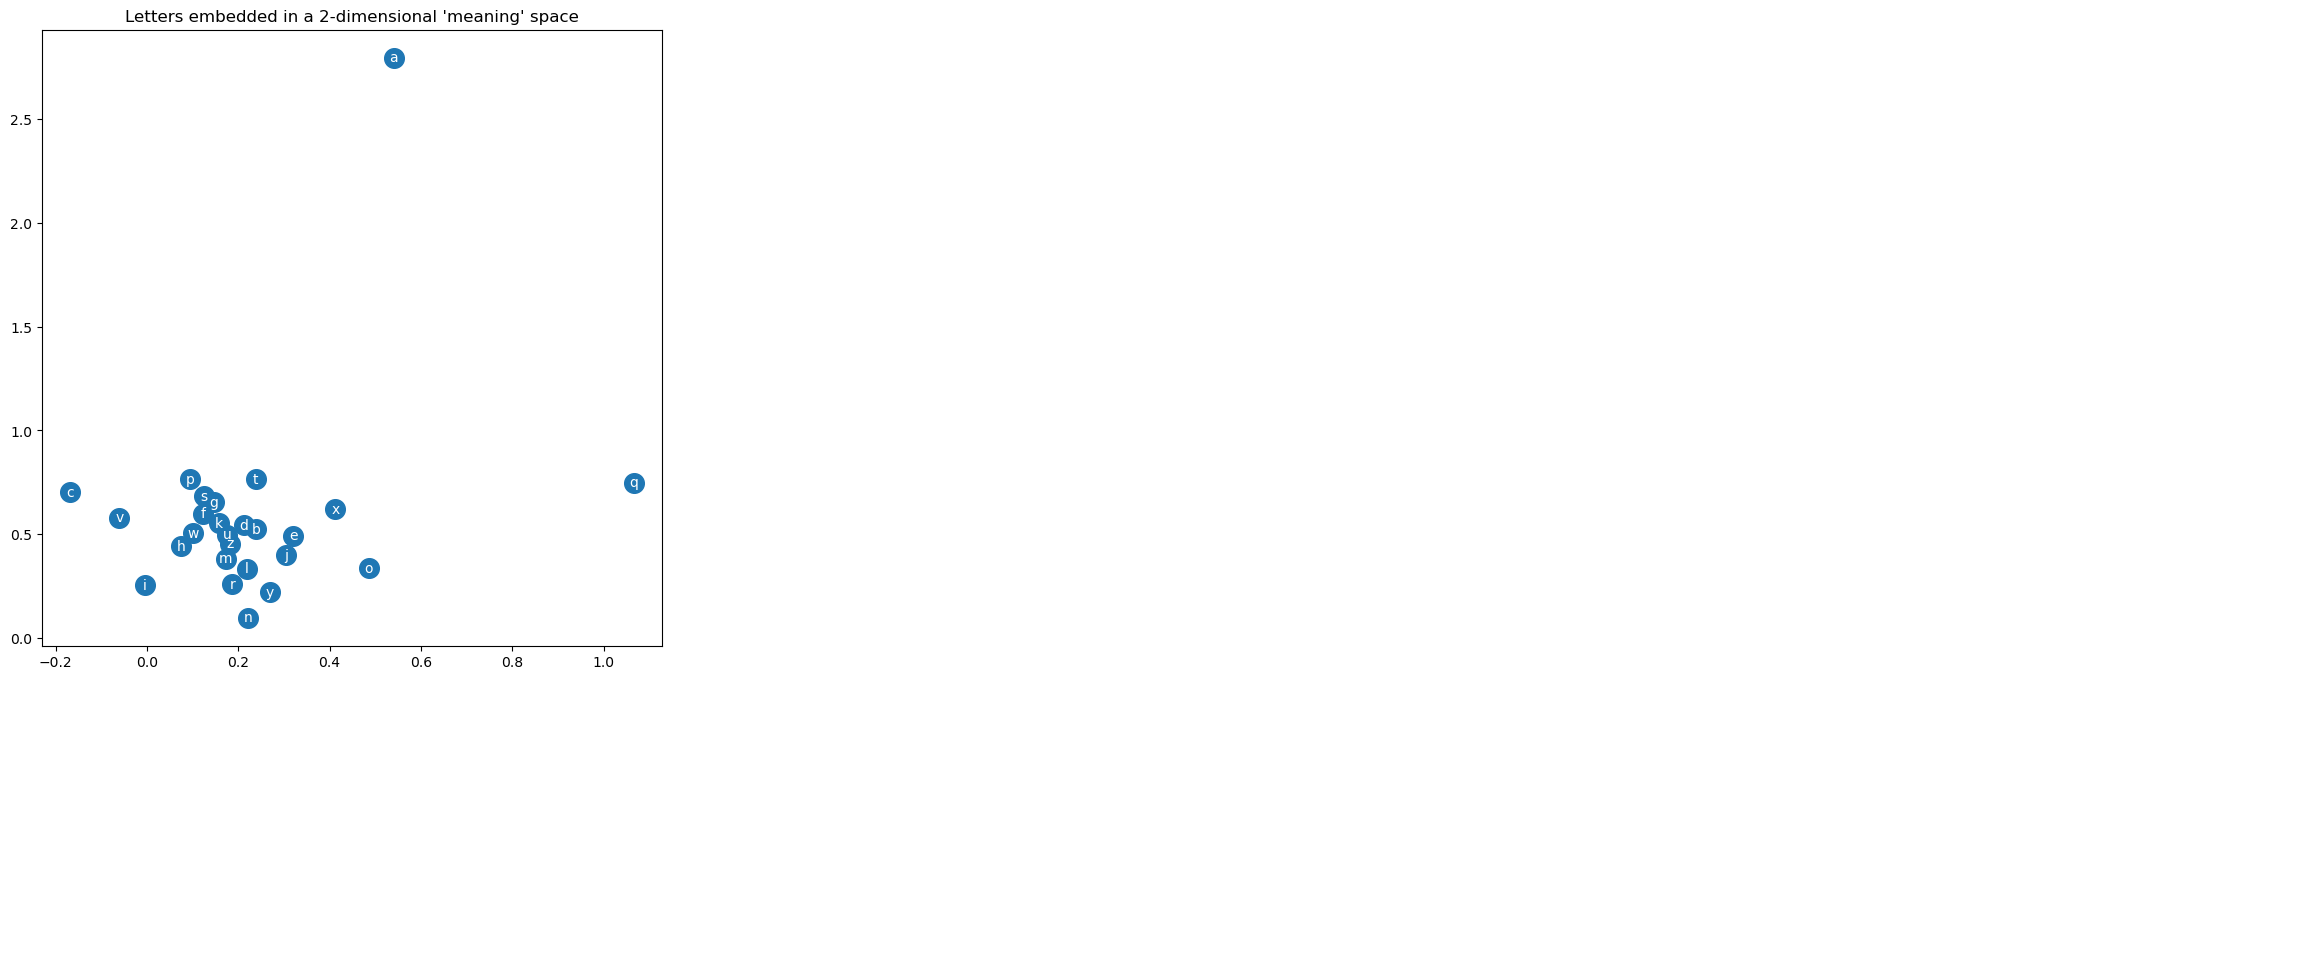

In [195]:

plt.figure(figsize=(8,8))
plt.scatter(C[1:,0].data, C[1:,1].data, s=200)
plt.title("Letters embedded in a 2-dimensional 'meaning' space")
for i in range(C.shape[0]):
    plt.text(C[i,0], C[i,1], itos[i], ha="center", va="center", color="white")

## Part 5: 10-dimensional embeddings

Due to a lack of progress in performance from our bigram exercise, we have decided that it is likely that the bottleneck of this net's performance is the limit on how it represents letters in a 2-dimensional space. Thus, we will increase the dimensionality.

In [187]:
def build_dataset(words):
    block_size = 4
    X, Y = [], [] # inputs and labels
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # shift context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80% of data
X_valid, Y_valid = build_dataset(words[n1:n2]) # 10% of data
X_test, Y_test = build_dataset(words[n2:]) # 10% of data

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


### 5.2 Final Attempt: Beat Andrej's loss

In [188]:
# hyper-parameters
eta = 0.1
epochs = 50000
batch_size = 32
block_size = 4
emb_dims = 10

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((block_size * emb_dims,400), generator=g)
b1 = torch.randn(400, generator=g)
W2 = torch.randn((400,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 27497


In [189]:
etas = []
losses = []

In [190]:

for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y_train[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    losses.append(loss.log10().item())
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad if epoch < epochs // 2 else -eta * p.grad * 0.01


Epoch 0: 34.817
Epoch 1: 29.721
Epoch 2: 31.542
Epoch 3: 27.559
Epoch 4: 30.739
Epoch 5: 27.514
Epoch 6: 27.757
Epoch 7: 31.326
Epoch 8: 27.551
Epoch 9: 26.570
Epoch 10: 31.451
Epoch 11: 26.616
Epoch 12: 26.838
Epoch 13: 21.602
Epoch 14: 30.221
Epoch 15: 25.399
Epoch 16: 25.627
Epoch 17: 19.703
Epoch 18: 28.489
Epoch 19: 22.924
Epoch 20: 21.968
Epoch 21: 26.128
Epoch 22: 18.248
Epoch 23: 16.649
Epoch 24: 21.210
Epoch 25: 24.014
Epoch 26: 24.733
Epoch 27: 17.583
Epoch 28: 15.947
Epoch 29: 29.083
Epoch 30: 17.869
Epoch 31: 21.703
Epoch 32: 22.625
Epoch 33: 17.794
Epoch 34: 17.908
Epoch 35: 17.653
Epoch 36: 21.765
Epoch 37: 19.485
Epoch 38: 23.999
Epoch 39: 22.511
Epoch 40: 23.286
Epoch 41: 23.722
Epoch 42: 16.988
Epoch 43: 16.976
Epoch 44: 17.699
Epoch 45: 27.321
Epoch 46: 18.804
Epoch 47: 16.133
Epoch 48: 18.415
Epoch 49: 15.578
Epoch 50: 16.808
Epoch 51: 13.216
Epoch 52: 19.767
Epoch 53: 14.256
Epoch 54: 12.365
Epoch 55: 16.732
Epoch 56: 14.996
Epoch 57: 15.546
Epoch 58: 14.355
Epoch 5

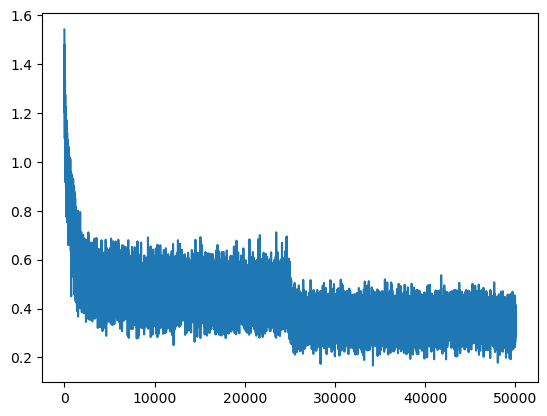

In [191]:
plt.plot(torch.linspace(0, len(losses), len(losses)), losses)

In [192]:
# validation
emb = C[X_valid] # (batch_size)
h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
logits = h @ W2 + b2 # (n, 27)
loss = F.cross_entropy(logits, Y_valid)
print(f"Validation loss: {loss.item():.3f}")

Validation loss: 2.268


In [193]:
# test
emb = C[X_test] # (batch_size)
h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
logits = h @ W2 + b2 # (n, 27)
loss = F.cross_entropy(logits, Y_test)
print(f"Test loss: {loss.item():.3f}")

Test loss: 2.271


#### Part 6: Feed the model

In [194]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)] # (batch_size)
        h = torch.tanh(emb.view(1, emb_dims * block_size) @ W1 + b1)
        logits = h @ W2 + b2 # (n, 27)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

selos.
abdailith.
bena.
caelhe.
avren.
cader.
lathian.
kyre.
dolses.
mrosty.
garlilemior.
hariyso.
tilam.
teron.
brunny.
evyla.
tayertanniy.
konncep.
kelb.
haja.
